# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Mishel Yusupov 5102
# student 2:

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_set = pd.read_csv("titanic_train.csv")  #טעינת הדאטה
test_set = pd.read_csv("titanic_test.csv")

print("Train set:\n")
print(train_set.head())  #הדפסה של 5 שורות ראשונות
print("\n\nTest set:\n")
print(test_set.head())

Train set:

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0


Test set:

   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1


In [4]:
print(train_set.info()) #הצגת מידע כללי על הדאטה
print("\n\n")
print(train_set.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int64  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    int64  
 7   Survived  712 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 44.6 KB
None



           Pclass         Sex         Age       SibSp       Parch        Fare  \
count  712.000000  712.000000  712.000000  712.000000  712.000000  712.000000   
mean     2.294944    0.640449   29.531213    0.528090    0.384831   32.379429   
std      0.841990    0.480206   13.188028    1.055052    0.803085   49.836074   
min      1.000000    0.000000    0.670000    0.000000    0.000000    0.000000   
25%      1.750000    0.000000   22.000000 

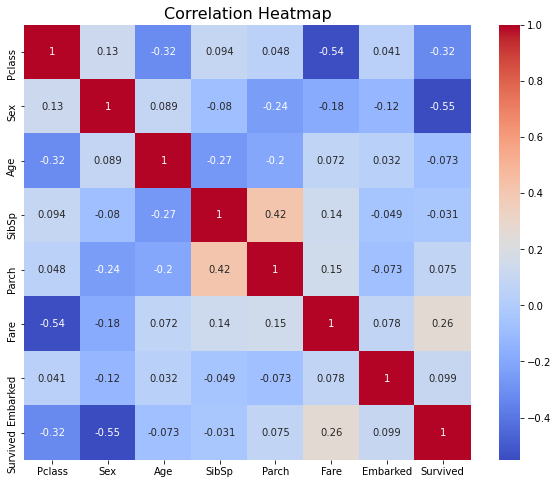

In [5]:
plt.figure(figsize=(10, 8)) #הכנה לגרף מפת חום
corr = train_set.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


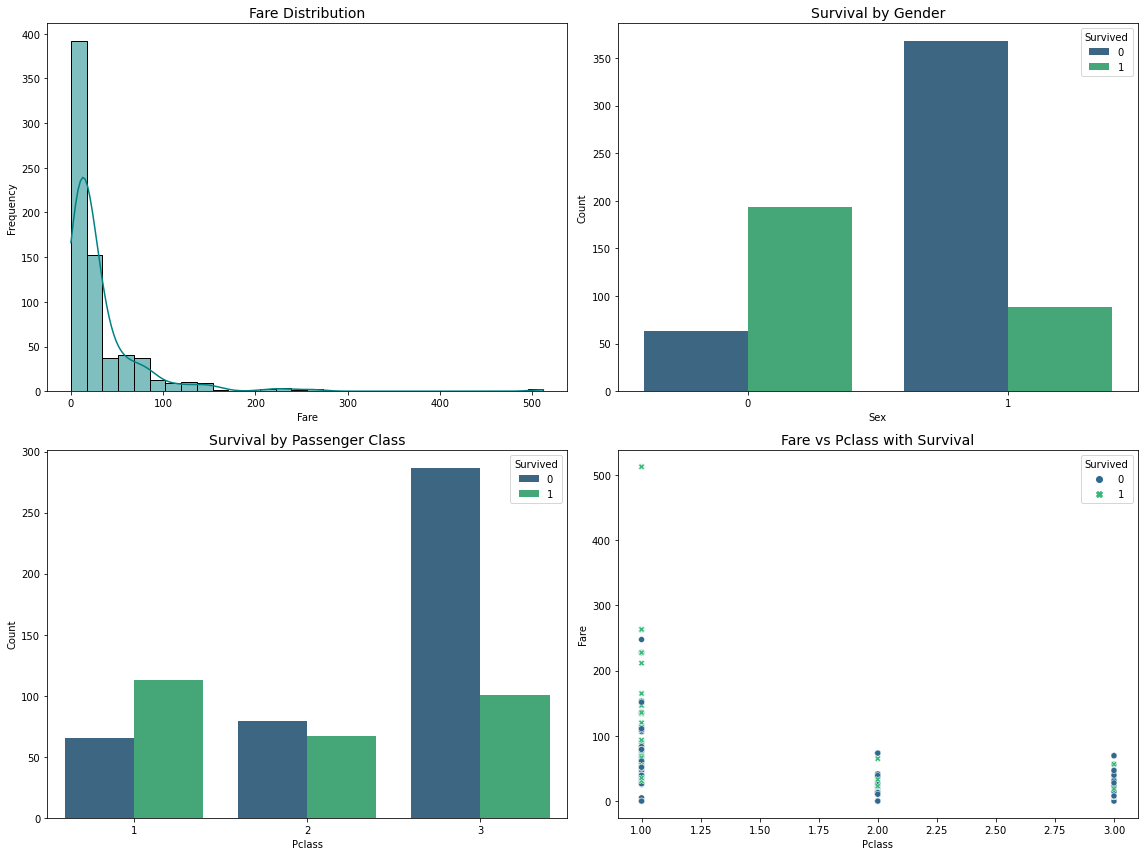

In [6]:
# הכנת 4 גרפים להצגת התפלגויות מעניינות לפי מה שניתן ללמוד ממפת החום
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# גרף התפלגות Fare
sns.histplot(data=train_set, x='Fare', bins=30, kde=True, ax=axes[0, 0], color='teal')
axes[0, 0].set_title('Fare Distribution', fontsize=14)
axes[0, 0].set_xlabel('Fare')
axes[0, 0].set_ylabel('Frequency')

# גרף התפלגות Survived לפי מין
sns.countplot(x='Sex', hue='Survived', data=train_set, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Survival by Gender', fontsize=14)
axes[0, 1].set_xlabel('Sex')
axes[0, 1].set_ylabel('Count')

# גרף התפלגות Survived לפי מחלקת הנסיעה (Pclass)
sns.countplot(x='Pclass', hue='Survived', data=train_set, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Survival by Passenger Class', fontsize=14)
axes[1, 0].set_xlabel('Pclass')
axes[1, 0].set_ylabel('Count')

# גרף אינטראקציה בין Pclass ל-Fare עם חלוקה לפי Survived
sns.scatterplot(x='Pclass', y='Fare', hue='Survived', data=train_set, palette='viridis', style='Survived', ax=axes[1, 1])
axes[1, 1].set_title('Fare vs Pclass with Survival', fontsize=14)
axes[1, 1].set_xlabel('Pclass')
axes[1, 1].set_ylabel('Fare')

# התאמת פריסת הגרפים
plt.tight_layout()

plt.show()


## Part 3 - Experiments
You could add as many code cells as needed

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV



In [8]:
# הגדרת משתנה המטרה והמאפיינים מהנתונים
y_train = train_set['Survived']
X_train = train_set.drop('Survived', axis=1)

# יצירת עותק עבור טיפול בחריגים ב Fare
X_train_winsorized = X_train.copy()
upper_limit = np.percentile(X_train_winsorized['Fare'], 95)
X_train_winsorized['Fare'] = np.where(X_train_winsorized['Fare'] > upper_limit, upper_limit, X_train_winsorized['Fare'])

# יצירת עותק נוסף עבור age binning עם winsorization
X_train_winsorized_age_grouped = X_train_winsorized.copy()
X_train_winsorized_age_grouped['Age_Group'] = pd.cut(X_train_winsorized['Age'], bins=[0, 12, 18, 50, 100], labels=['Child', 'Teen', 'Adult', 'Senior'])
X_train_winsorized_age_grouped = pd.get_dummies(X_train_winsorized_age_grouped, columns=['Age_Group'], drop_first=True)
X_train_winsorized_age_grouped = X_train_winsorized_age_grouped.drop('Age', axis=1)


In [9]:
# הגדרת scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()

# רשימה של כל סטי הנתונים וה-Scaler שלהם
datasets = [
    ("Original Dataset (Standard Scaler)", X_train, scaler_standard),
    ("Original Dataset (Min-Max Scaler)", X_train, scaler_minmax),
    ("Original Dataset (Robust Scaler)", X_train, scaler_robust),
    ("Processed Dataset with 'Fare' limit (Standard Scaler)", X_train_winsorized, scaler_standard),
    ("Processed Dataset with 'Fare' limit (Min-Max Scaler)", X_train_winsorized, scaler_minmax),
    ("Processed Dataset with 'Fare' limit (Robust Scaler)", X_train_winsorized, scaler_robust),
    ("Processed Dataset with 'Fare' limit and 'Age' grouped (Standard Scaler)", X_train_winsorized_age_grouped, scaler_standard),
    ("Processed Dataset with 'Fare' limit and 'Age' grouped (Min-Max Scaler)", X_train_winsorized_age_grouped, scaler_minmax),
    ("Processed Dataset with 'Fare' limit and 'Age' grouped (Robust Scaler)", X_train_winsorized_age_grouped, scaler_robust),
]

# הגדרת מדד F1 Macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# הגדרת היפר-פרמטרים לכל מודל
param_grids = {
    "Decision Tree": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 10, 20],
        'min_samples_split': [2, 5, 10],
    },
    "Logistic Regression": {
        'C': [0.01, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [5, 10]
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

# הגדרת המודלים
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}

results = pd.DataFrame(columns=["Model", "Data Set", "Best Parameters", "F1 Macro Score"])

# הרצת GridSearch על כל סטי הנתונים
for name, model in models.items():
    for dataset_name, dataset, scaler in datasets:
        # נרמול הנתונים
        X_train_scaled = scaler.fit_transform(dataset)

        # הרצת GridSearchCV
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring=f1_macro_scorer)
        grid_search.fit(X_train_scaled, y_train)
    
        # שמירת התוצאות
        results = results.append({
            "Model": name,
            "Data Set": dataset_name,
            "Best Parameters": grid_search.best_params_,
            "F1 Macro Score": grid_search.best_score_
        }, ignore_index=True)


In [10]:

# מציאת התוצאה הטובה ביותר עבור כל מודל
best_results = results.loc[results.groupby("Model")["F1 Macro Score"].idxmax()]

# הדפסת התוצאות המסוננות
print("\nBest Results DataFrame:")
print(best_results.to_string())

# הדפסת המודל עם הביצועים הטובים ביותר בכללי
best_model_row = best_results.loc[best_results['F1 Macro Score'].idxmax()]
print(f"\nOverall Best model: {best_model_row['Model']} on {best_model_row['Data Set']} with {best_model_row['Best Parameters']} and F1 Macro Score of {best_model_row['F1 Macro Score']:.4f}")



Best Results DataFrame:
                  Model                                                                 Data Set                                                 Best Parameters  F1 Macro Score
0         Decision Tree                                       Original Dataset (Standard Scaler)   {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}        0.795636
33                  KNN  Processed Dataset with 'Fare' limit and 'Age' grouped (Standard Scaler)                        {'n_neighbors': 7, 'weights': 'uniform'}        0.792692
10  Logistic Regression                                        Original Dataset (Min-Max Scaler)                                {'C': 10, 'solver': 'liblinear'}        0.791203
21        Random Forest                    Processed Dataset with 'Fare' limit (Standard Scaler)  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}        0.815667

Overall Best model: Random Forest on Processed Dataset with 'Fare' limit (Standard Scaler

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [11]:
# הגדרת הקומבינציה המוצלחת ביותר
best_model_name = best_model_row['Model']
best_dataset_name = best_model_row['Data Set']
best_params = best_model_row['Best Parameters']

# מציאת סט הנתונים וה-scaler הרלוונטיים מתוך הרשימה
for dataset_name, dataset, scaler in datasets:
    if dataset_name == best_dataset_name:
        X_train_best = dataset
        scaler_best = scaler
        break

# נרמול הנתונים הטובים ביותר עם scaler המתאים
X_train_scaled_best = scaler_best.fit_transform(X_train_best)

# מיפוי שמות המודלים למחלקות המתאימות
model_classes = {
    "Decision Tree": DecisionTreeClassifier,
    "Logistic Regression": LogisticRegression,
    "Random Forest": RandomForestClassifier,
    "KNN": KNeighborsClassifier
}

# יצירת המודל המוצלח ביותרלפי השם והפרמטרים
best_model = model_classes[best_model_name](**best_params)

# אימון המודל עם כל ה-train set
best_model.fit(X_train_scaled_best, y_train)

# חיזוי על הסט המאומן
y_train_pred = best_model.predict(X_train_scaled_best)

# הצגת 5 השורות הראשונות של התוצאות
print("\nFirst 5 predicted results:")
print(y_train_pred[:5])

# חישוב מדד F1 Macro על הסט המאומן
f1_macro = f1_score(y_train, y_train_pred, average='macro')
print(f"\nF1 Macro Score on the train set: {f1_macro:.4f}")

print(f"\nModel '{best_model_name}' trained successfully with the best dataset '{best_dataset_name}' and parameters {best_params}.")



First 5 predicted results:
[1 1 0 0 0]

F1 Macro Score on the train set: 0.9054

Model 'Random Forest' trained successfully with the best dataset 'Processed Dataset with 'Fare' limit (Standard Scaler)' and parameters {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}.


## Part 5 - Apply on test and show model performance estimation

In [13]:
# הנחת נתוני ה-test 
y_test = test_set['Survived']
X_test = test_set.drop('Survived', axis=1)

# הפעלת אותו Feature Engineering על ה-test set לפי הקומבינציה הטובה ביותר:
X_test_best = X_test.copy()

if "Fare limit" in best_dataset_name:
    upper_limit = np.percentile(X_test_best['Fare'], 95)
    X_test_best['Fare'] = np.where(X_test_best['Fare'] > upper_limit, upper_limit, X_test_best['Fare'])

if "Age grouped" in best_dataset_name:
    X_test_best['Age_Group'] = pd.cut(X_test_best['Age'], bins=[0, 12, 18, 50, 100], labels=['Child', 'Teen', 'Adult', 'Senior'])
    X_test_best = pd.get_dummies(X_test_best, columns=['Age_Group'], drop_first=True)
    X_test_best = X_test_best.drop('Age', axis=1)

# מציאת עמודות חסרות והוספתן ל-Test עם ערך ברירת מחדל של 0
missing_cols = set(X_train_best.columns) - set(X_test_best.columns)
for col in missing_cols:
    X_test_best[col] = 0

# וידוא סדר העמודות של ה-Test תואם ל-Train
X_test_best = X_test_best[X_train_best.columns]

# נרמול ה-test set עם אותו Scaler בו השתמשנו ב-train
X_test_scaled_best = scaler_best.transform(X_test_best)

# חיזוי על ה-test set עם המודל המאומן
y_test_pred = best_model.predict(X_test_scaled_best)

# הצגת 5 השורות הראשונות של התוצאות ב-test
print("\nFirst 5 predicted results on the test set:")
print(y_test_pred[:5])

# חישוב מדד F1 Macro על ה-test set
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
print(f"\nF1 Macro Score on the test set: {f1_macro_test:.2f}")

print(f"\nModel '{best_model_name}' tested successfully on the test set using the best dataset '{best_dataset_name}' and parameters {best_params}.")

# יצירת DataFrame להשוואת תחזיות לתוצאות האמיתיות
comparison_df = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_test_pred
})

# הצגת 5 השורות הראשונות של DataFrame
print("\nComparison of True vs Predicted (first 5 rows):")
print(comparison_df.head())



First 5 predicted results on the test set:
[0 0 0 1 1]

F1 Macro Score on the test set: 0.88

Model 'Random Forest' tested successfully on the test set using the best dataset 'Processed Dataset with 'Fare' limit (Standard Scaler)' and parameters {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}.

Comparison of True vs Predicted (first 5 rows):
   True Values  Predicted Values
0            0                 0
1            0                 0
2            0                 0
3            0                 1
4            1                 1
